In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from scipy.spatial.distance import mahalanobis
from scipy.linalg import cho_factor, cho_solve

class PADIM:
    def __init__(self, decision_radius: float = 0.5, layer='conv3_block4_out'):
        self.decision_radius = decision_radius
        self.layer = layer
        self._build_feature_extractor()  # initialise self.model
        self.mean_map = {}
        self.cov_map = {}
        self.n_sample = 0

    def _build_feature_extractor(self):
        input_tensor = Input(shape=(224, 224, 3))
        base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=input_tensor)
        self.model = Model(inputs=input_tensor, outputs=base_model.get_layer(self.layer).output)

    def _extract_features(self, images):
        features = self.model.predict(images, verbose=0)
        features = features.reshape(features.shape[0], -1, features.shape[-1])
        return features  # shape (n_images, 784, 512)

    def _update_mean_cov(self, batch, mean_t, cov_t, n_t):
        """
        Met à jour la moyenne, la matrice de covariance et le nombre d'observations avec un batch de données.
        Args:
            batch (np.ndarray): Batch de données de forme (m, d).
            mean_t (np.ndarray or None): Moyenne à l'itération t, de forme (d,).
            cov_t (np.ndarray or None): Matrice de covariance à l'itération t, de forme (d, d).
            n_t (int): Nombre total d'observations jusqu'à l'itération t.
        Returns:
            tuple: (Nouvelle moyenne, Nouvelle matrice de covariance, Nombre total d'observations)
        """
        m = len(batch)
        # Initialisation
        if n_t == 0:
            mean_t = np.mean(batch, axis=0)
            cov_t = np.cov(batch, rowvar=False)
            return mean_t, cov_t, m
        # Mise à jour
        n_new = n_t + m
        batch_mean = np.mean(batch, axis=0)
        new_mean = mean_t + (m / n_new) * (batch_mean - mean_t)
        # Mise à jour de la covariance
        # Recalcul de S_t
        S_t = cov_t * n_t
        # Calcul des produits extérieurs centrés
        for x in batch:
            S_t += np.outer(x - mean_t, x - new_mean)
        # Nouvelle matrice de covariance
        cov_matrix = S_t / n_new
        return new_mean, cov_matrix, n_new

    def batch_fit(self, image_batch) -> None:
        """
        images: batch au format adapté pour une classification par le RESNET50.
        """
        features = self._extract_features(image_batch)
        for i in range(features.shape[1]):  # pour chaque feature
            patch_features = features[:, i, :]  # m=10 images, feature de taille d=512
            self.mean_map[i], self.cov_map[i], self.n_sample = self._update_mean_cov(patch_features,
                                                     self.mean_map.get(i, False),
                                                     self.cov_map.get(i, False),
                                                     self.n_sample)

    def batch_predict(self, image_batch) -> list[bool]:
        """
        images: batch au format adapté pour une classification par le RESNET50.
        """
        features = self._extract_features(image_batch)
        anomaly_maps = []
        for sample_idx in range(features.shape[0]):
            sample_anomalies = []
            for patch_idx in range(features.shape[1]):
                patch_feature = features[sample_idx, patch_idx, :]
                mean = self.mean_map[patch_idx]
                cov = self.cov_map[patch_idx]
                try:
                    c, low = cho_factor(cov)
                    inv_cov = cho_solve((c, low), np.zeros(cov.shape[0]))
                    dist = mahalanobis(patch_feature, mean, inv_cov)
                except np.linalg.LinAlgError:
                    dist = 0.0
                sample_anomalies.append(dist)
            anomaly_maps.append(np.array(sample_anomalies).reshape(2 * [int(np.sqrt(len(sample_anomalies)))]))
        decision = []  # indice i = True : pas d'anomalie.
        for map in anomaly_maps:
            anomaly_score = 1 / (1 + np.max(map))
            if anomaly_score > self.decision_radius:
                decision.append(False)
            else:
              decision.append(True)
        return decision

In [ ]:
# Montage du drive
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Chargement des labels (sous forme de dataframe)
import pandas as pd

labels = pd.read_csv("/content/drive/MyDrive/labels.csv")
labels.head()

,Unnamed: 0,filename,window,lib,Label
0,0,15b3bab7c186fd35b65df777890c427dd243feacbb85dd...,2003,Die01,Missing
1,1,1856617e1ac2d821a46a41b938818f0169342226a78f93...,2003,Die01,GOOD
2,2,19066cce773b3a092ebf4311b11858aa653da6f8274957...,2003,Die01,Missing
3,3,19c10caf4b24284e1748caed62d94cbb689d6b379b1cf5...,2003,Die01,GOOD
4,4,1a627426d55a668df8bcd381a7fa87b620481995b6755f...,2003,Die01,Missing


In [ ]:
# Chargement en local des images (éviter le warm-up effect)
import os

if not os.path.exists("/content/data"):
    print("📁 Copie des fichiers depuis Google Drive...")
    !cp -r "/content/drive/MyDrive/GOOD_images" "/content/data"
    print("✅ Copie terminée.")
else:
    print("✅ Dossier déjà présent : aucune copie nécessaire.")

✅ Dossier déjà présent : aucune copie nécessaire.


In [ ]:
# Entraînement
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.model_selection import train_test_split
import pickle
from tqdm import tqdm

def load_batch(batch_paths):
    images = []
    for path in batch_paths:
        img = load_img(path, target_size=(224, 224))
        img_array = img_to_array(img) / 255.0  # Normalisation
        images.append(img_array)
    return np.array(images)

padim = PADIM()
good_labels = labels[labels["Label"] == "GOOD"]  # on se focus sur le label good.
train_labels, test_labels = train_test_split(good_labels, test_size=0.2, random_state=42)
data_path = "/content/data/"
batch_size = 32
n_batches = len(train_labels) // batch_size
for i in tqdm(range(n_batches), desc="training..."):
    batch_paths = train_labels.iloc[i * batch_size : (i + 1) * batch_size]["filename"].apply(lambda x: data_path + "proc_" + x)
    batch = load_batch(batch_paths)
    padim.batch_fit(batch)
save_path = "/content/drive/MyDrive/model/padim_002.pkl"
with open(save_path, "wb") as file:
    pickle.dump(padim, file)

training...: 100%|██████████| 30/30 [03:37<00:00,  7.25s/it]


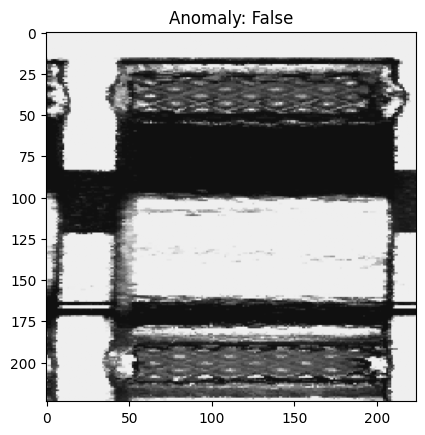

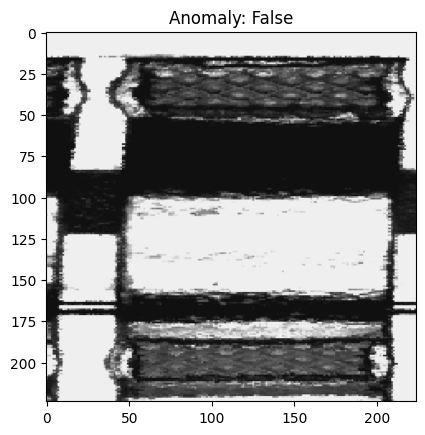

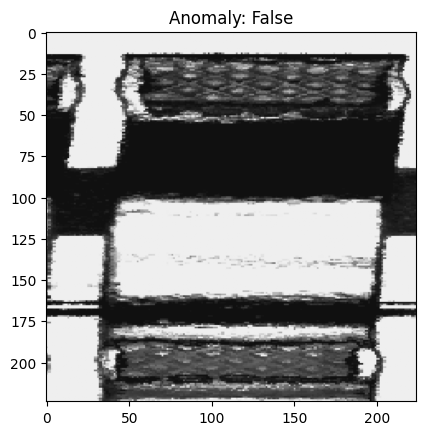

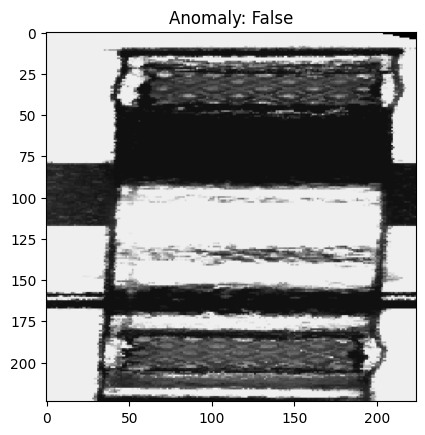

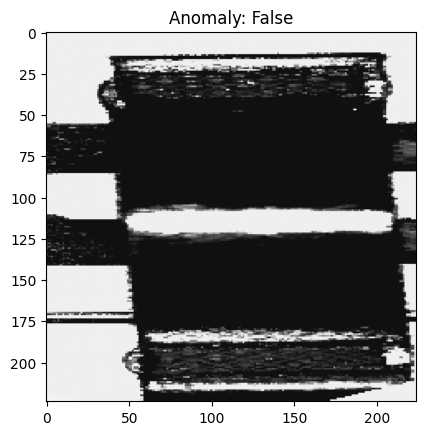

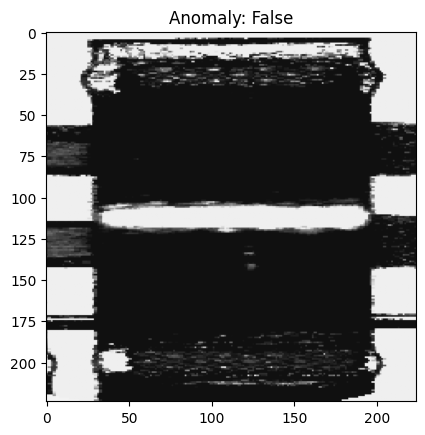

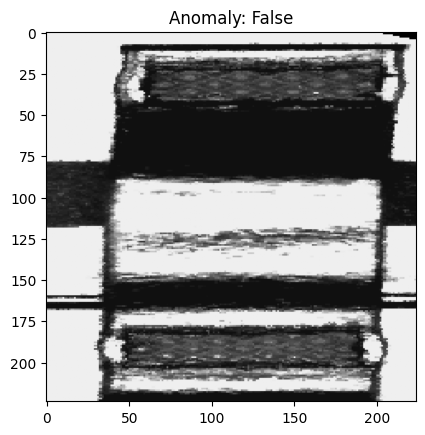

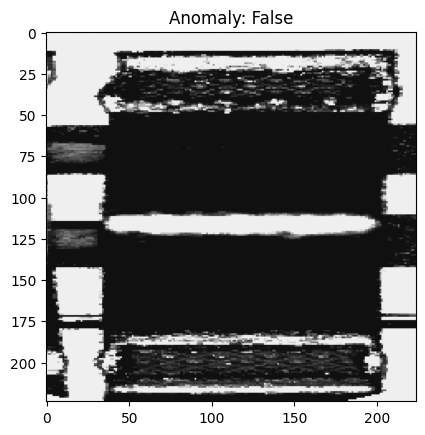

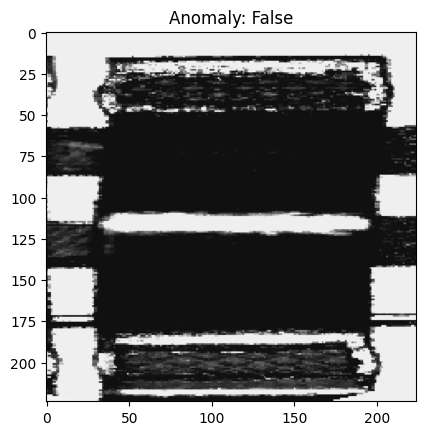

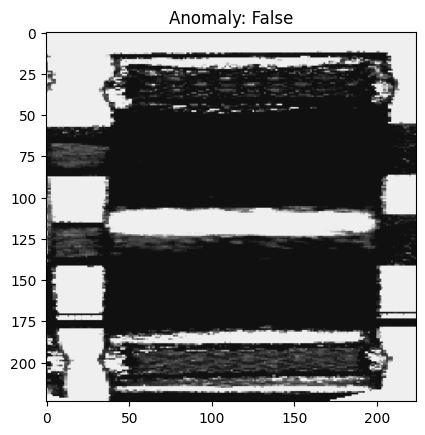

In [ ]:
# Test
import matplotlib.pyplot as plt

test_paths = test_labels["filename"].iloc[0 : batch_size].apply(lambda x: data_path + "proc_" + x)
test_batch = load_batch(test_paths)
anomalies = padim.batch_predict(test_batch)
for i in range(10):
    plt.imshow(test_batch[i])
    plt.title(f"Anomaly: {anomalies[i]}")
    plt.show()